In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

# **Wstępna eksploracja danych**

In [152]:
df = pd.read_csv("movies_preprocessed.csv")

df_score = pd.read_csv("q_movies.csv")
df_score.head(1)

,title,genres,overview,tagline,release_date,budget,revenue,profit,popularity,runtime,vote_average,vote_count,cast,director,reviews,original_language,spoken_languages,production_companies,production_countries,score
0,The Shawshank Redemption,"['Drama', 'Crime']",Framed in the 1940s for the double murder of h...,Fear can hold you prisoner. Hope can set you f...,1994-09-23,25000000.0,28341469.0,3341469.0,74.768,142,8.703,23906,"[{'name': 'Tim Robbins', 'popularity': 21.182}...","{'name': 'Frank Darabont', 'popularity': 14.413}","['very good movie 9.5/10 محمد الشعراوى', 'Some...",en,['en'],['Castle Rock Entertainment'],['US'],8.44981


In [153]:
df.describe()

,budget,revenue,profit,popularity,runtime,vote_average,vote_count
count,9.924000e+03,9.924000e+03,9.924000e+03,9924.000000,9924.000000,9924.000000,9924.000000
mean,1.988750e+07,6.064824e+07,4.076074e+07,29.051713,101.508867,6.328681,1554.828597
std,3.845721e+07,1.549626e+08,1.288227e+08,85.264696,26.735137,1.411921,2889.777920
min,0.000000e+00,0.000000e+00,-3.000000e+08,7.008000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,13.178000,90.000000,5.909750,144.000000
50%,1.322000e+06,2.089185e+06,0.000000e+00,17.002000,100.000000,6.541500,504.500000
75%,2.300000e+07,5.069600e+07,2.847482e+07,25.611250,115.000000,7.137000,1578.000000
max,4.600000e+08,2.923706e+09,2.686706e+09,4071.868000,317.000000,10.000000,33795.000000


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9924 entries, 0 to 9923
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 9924 non-null   object 
 1   genres                9924 non-null   object 
 2   overview              9856 non-null   object 
 3   tagline               7337 non-null   object 
 4   release_date          9921 non-null   object 
 5   budget                9924 non-null   float64
 6   revenue               9924 non-null   float64
 7   profit                9924 non-null   float64
 8   popularity            9924 non-null   float64
 9   runtime               9924 non-null   int64  
 10  vote_average          9924 non-null   float64
 11  vote_count            9924 non-null   int64  
 12  cast                  9924 non-null   object 
 13  director              9869 non-null   object 
 14  reviews               9924 non-null   object 
 15  original_language    

In [155]:
df["release_date"] = pd.to_datetime(df["release_date"])
mean_date = df["release_date"].mean()
mean_date

Timestamp('2007-07-25 04:36:47.680677376')

In [156]:
df["genres"] = df["genres"].apply(ast.literal_eval)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9924 entries, 0 to 9923
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 9924 non-null   object        
 1   genres                9924 non-null   object        
 2   overview              9856 non-null   object        
 3   tagline               7337 non-null   object        
 4   release_date          9921 non-null   datetime64[ns]
 5   budget                9924 non-null   float64       
 6   revenue               9924 non-null   float64       
 7   profit                9924 non-null   float64       
 8   popularity            9924 non-null   float64       
 9   runtime               9924 non-null   int64         
 10  vote_average          9924 non-null   float64       
 11  vote_count            9924 non-null   int64         
 12  cast                  9924 non-null   object        
 13  director          

## Wykres popularności 50 filmów

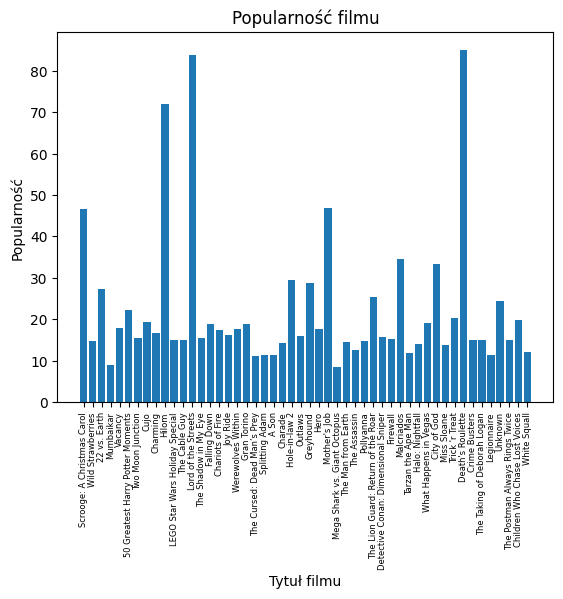

In [157]:
sample_df = df.sample(n=50)
plt.bar(sample_df["title"], sample_df["popularity"])
plt.xlabel("Tytuł filmu")
plt.ylabel("Popularność")
plt.title("Popularność filmu")
plt.xticks(rotation=90, fontsize=6)
plt.show()

del sample_df

## Wykres popularności danego gatunku

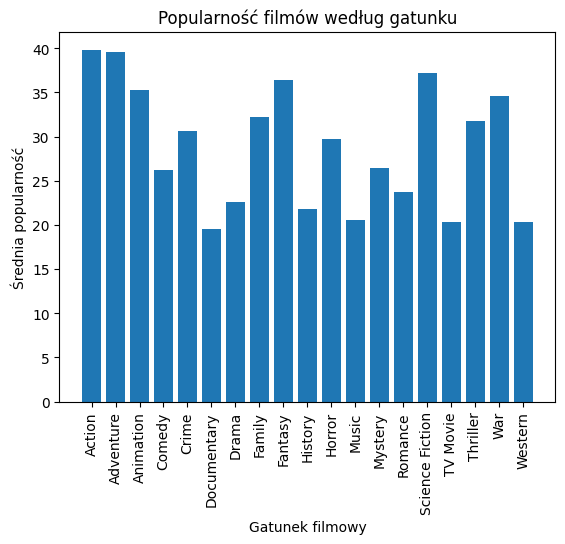

In [158]:
# Rozbicie listy gatunków na osobne wiersze
genres_df = df.explode("genres")

# Obliczenie średniej popularności dla każdego gatunku
average_popularity = genres_df.groupby("genres")["popularity"].mean()

# Wygenerowanie wykresu słupkowego
plt.bar(average_popularity.index, average_popularity)
plt.xlabel("Gatunek filmowy")
plt.ylabel("Średnia popularność")
plt.title("Popularność filmów według gatunku")
plt.xticks(rotation=90)
plt.show()

## Wykres kołowy ilości filmów danego gatunku

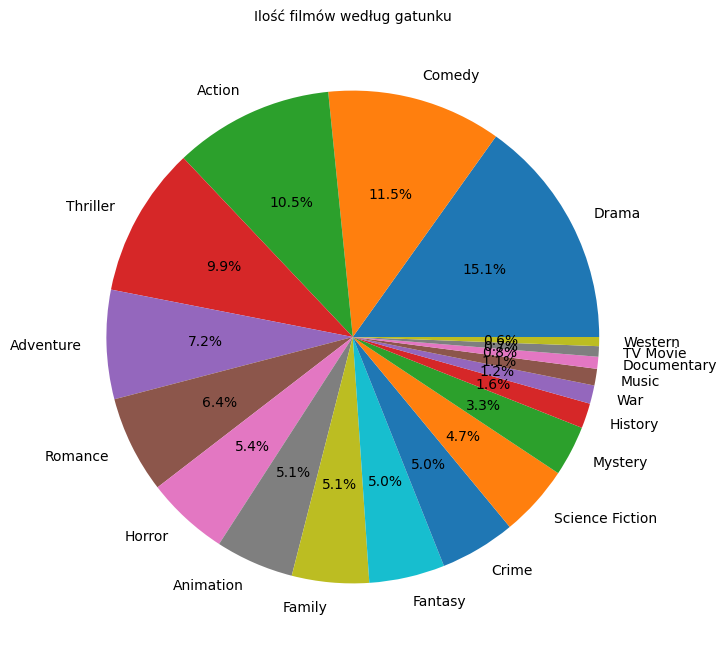

In [159]:
# Zliczenie liczby filmów dla każdego gatunku
genre_counts = genres_df["genres"].value_counts()

# Wygenerowanie wykresu kołowego
plt.figure(figsize=(8, 8))  # Ustawienie większego rozmiaru wykresu (np. 8x8 cali)

plt.pie(
    genre_counts,
    labels=genre_counts.index,
    autopct="%1.1f%%",
    textprops={"fontsize": 10},
)  # Zmniejszenie czcionki na etykietach

plt.title("Ilość filmów według gatunku", fontsize=10)  # Zmniejszenie czcionki na tytule

plt.show()

## Macierz korelacji

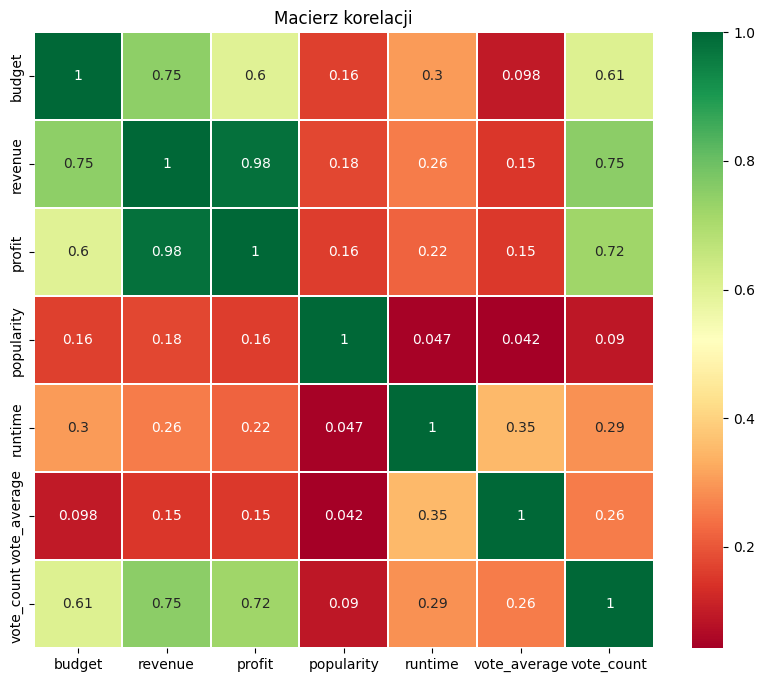

In [160]:
# Wygenerowanie macierzy korelacji
numeric_columns = df.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_columns.corr()

# Wygenerowanie wykresu korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", linewidths=0.2)
plt.title("Macierz korelacji")
plt.show()

## Średnia długość filmów

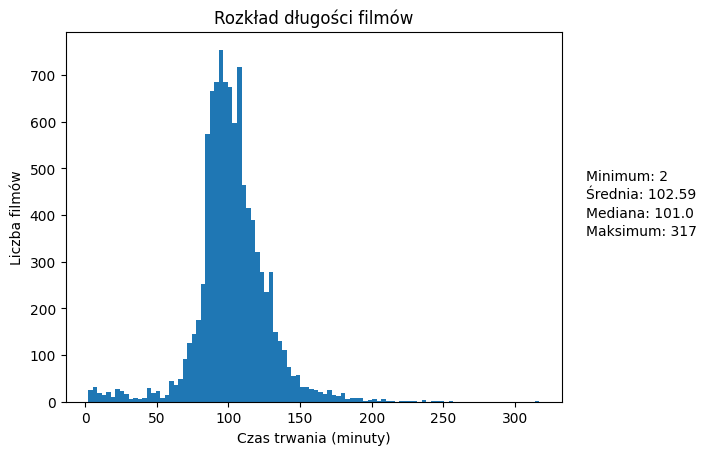

In [161]:
df_cleaned = df[(df["runtime"] > 0)]

minimum = df_cleaned["runtime"].min()
mean = df_cleaned["runtime"].mean()
median = df_cleaned["runtime"].median()
maximum = df_cleaned["runtime"].max()

# Wyświetlanie wartości statystycznych
plt.text(1.05, 0.6, f"Minimum: {minimum}", transform=plt.gca().transAxes)
plt.text(1.05, 0.55, f"Średnia: {mean:.2f}", transform=plt.gca().transAxes)
plt.text(1.05, 0.5, f"Mediana: {median}", transform=plt.gca().transAxes)
plt.text(1.05, 0.45, f"Maksimum: {maximum}", transform=plt.gca().transAxes)

plt.hist(df_cleaned["runtime"], bins=100)
plt.xlabel("Czas trwania (minuty)")
plt.ylabel("Liczba filmów")
plt.title("Rozkład długości filmów")
plt.show()

del df_cleaned

## Analiza dat wydania analizowanych filmów

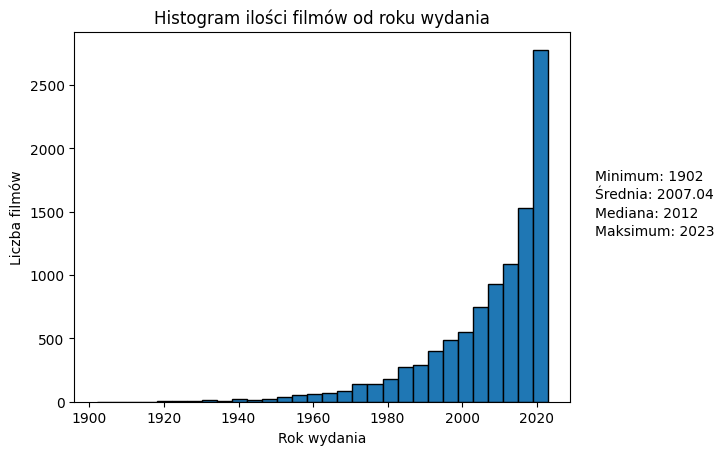

In [162]:
# Wyodrębnienie roku wydania filmu
df["release_year"] = pd.to_datetime(df["release_date"]).dt.year

# Tworzenie histogramu
plt.hist(df["release_year"], bins=30, edgecolor="black")

# Obliczenie wartości statystycznych
minimum = df["release_year"].min()
mean = df["release_year"].mean()
median = df["release_year"].median()
maximum = df["release_year"].max()

# Wyświetlanie wartości statystycznych
plt.text(1.05, 0.6, f"Minimum: {int(minimum)}", transform=plt.gca().transAxes)
plt.text(1.05, 0.55, f"Średnia: {mean:.2f}", transform=plt.gca().transAxes)
plt.text(1.05, 0.5, f"Mediana: {int(median)}", transform=plt.gca().transAxes)
plt.text(1.05, 0.45, f"Maksimum: {int(maximum)}", transform=plt.gca().transAxes)

# Konfiguracja wykresu
plt.title("Histogram ilości filmów od roku wydania")
plt.xlabel("Rok wydania")
plt.ylabel("Liczba filmów")

# Wyświetlenie wykresu
plt.show()

## Budżet, dochód i zysk

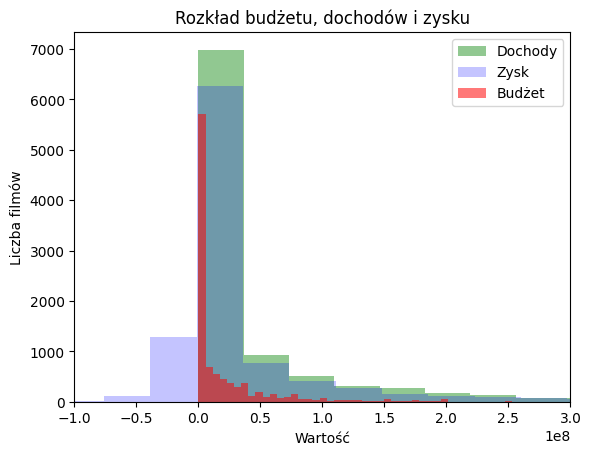

In [163]:
plt.hist(df["revenue"], bins=80, color="green", alpha=0.43, label="Dochody")
plt.hist(df["profit"], bins=80, color="blue", alpha=0.23, label="Zysk")
plt.hist(df["budget"], bins=80, color="red", alpha=0.53, label="Budżet")
plt.xlim(-100000000, 300000000)  # Ustawienie zakresu osi x
plt.xlabel("Wartość")
plt.ylabel("Liczba filmów")
plt.title("Rozkład budżetu, dochodów i zysku")
plt.legend()
plt.show()

## Histogram języków

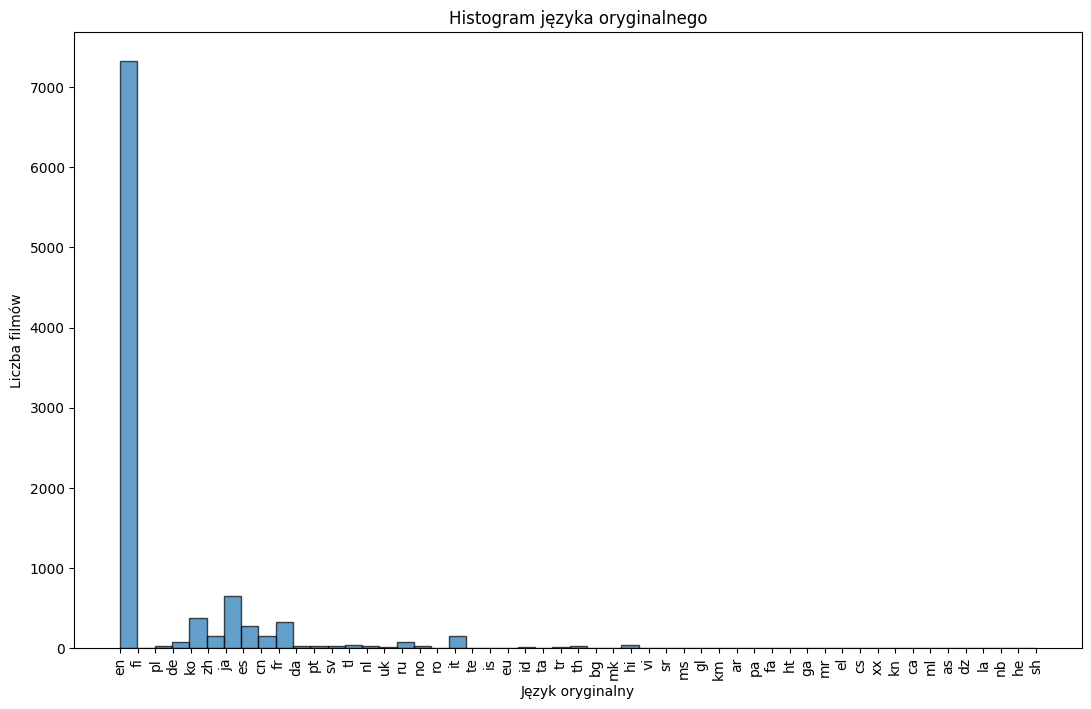

In [164]:
# Obliczenie liczby unikalnych języków oryginalnych
unique_languages = df["original_language"].nunique()

# Tworzenie histogramu
plt.figure(figsize=(13, 8))
plt.hist(df["original_language"], bins=unique_languages, edgecolor="black", alpha=0.7)
plt.xlabel("Język oryginalny")
plt.ylabel("Liczba filmów")
plt.title("Histogram języka oryginalnego")

# Obrót etykiet osi x
plt.xticks(rotation=90, fontsize=10)
# Wyświetlenie wykresu
plt.show()

In [165]:
num_zero_budget = len(df[df["budget"] == 0])
print(f"Liczba filmów, gdzie budżet wynosi 0: {num_zero_budget}")
num_zero_profit = len(df[df["profit"] == 0])
print(f"Liczba filmów, gdzie zysk wynosi 0: {num_zero_profit}")
num_zero_revenue = len(df[df["revenue"] == 0])
print(f"Liczba filmów, gdzie dochód wynosi 0: {num_zero_revenue}")

Liczba filmów, gdzie budżet wynosi 0: 4612
Liczba filmów, gdzie zysk wynosi 0: 3684
Liczba filmów, gdzie dochód wynosi 0: 4352


In [166]:
# Wyświetlenie ilości wierszy
print("Ilość filmów przed: ", df.shape[0])

# Filtrowanie danych filmów, gdzie budżet i zysk są większe od zera
filtered_df = df_score[(df_score["budget"] > 0) & (df_score["revenue"] > 0)]
print("Ilość filmów po: ", filtered_df.shape[0])

Ilość filmów przed:  9924
Ilość filmów po:  1436


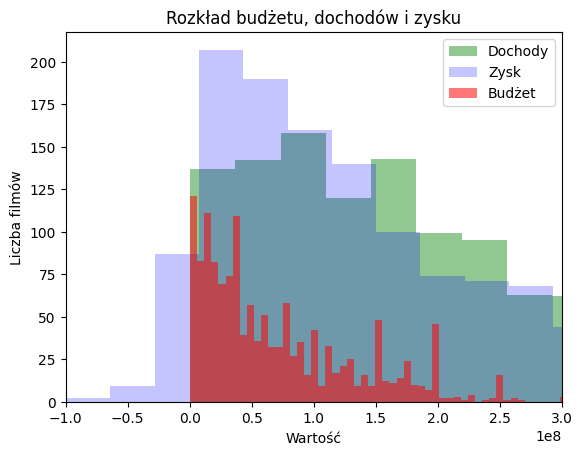

In [167]:
plt.hist(filtered_df["revenue"], bins=80, color="green", alpha=0.43, label="Dochody")
plt.hist(filtered_df["profit"], bins=80, color="blue", alpha=0.23, label="Zysk")
plt.hist(filtered_df["budget"], bins=80, color="red", alpha=0.53, label="Budżet")
plt.xlim(-100000000, 300000000)  # Ustawienie zakresu osi x
plt.xlabel("Wartość")
plt.ylabel("Liczba filmów")
plt.title("Rozkład budżetu, dochodów i zysku")
plt.legend()
plt.show()

## Rozkład ocen

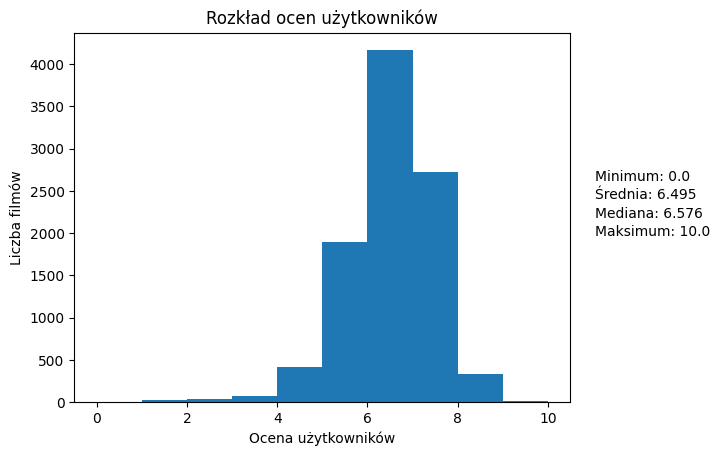

In [207]:
filtered_votes = df[(df["vote_count"] > 0)]

# Obliczenie wartości statystycznych
minimum = filtered_votes["vote_average"].min()
mean = filtered_votes["vote_average"].mean()
median = filtered_votes["vote_average"].median()
maximum = filtered_votes["vote_average"].max()

plt.hist(filtered_votes["vote_average"], bins=10)
plt.xlabel("Ocena użytkowników")
plt.ylabel("Liczba filmów")
plt.title("Rozkład ocen użytkowników")

# Wyświetlanie wartości statystycznych
plt.text(1.05, 0.6, f"Minimum: {minimum}", transform=plt.gca().transAxes)
plt.text(1.05, 0.55, f"Średnia: {mean:.3f}", transform=plt.gca().transAxes)
plt.text(1.05, 0.5, f"Mediana: {median}", transform=plt.gca().transAxes)
plt.text(1.05, 0.45, f"Maksimum: {maximum}", transform=plt.gca().transAxes)

plt.show()

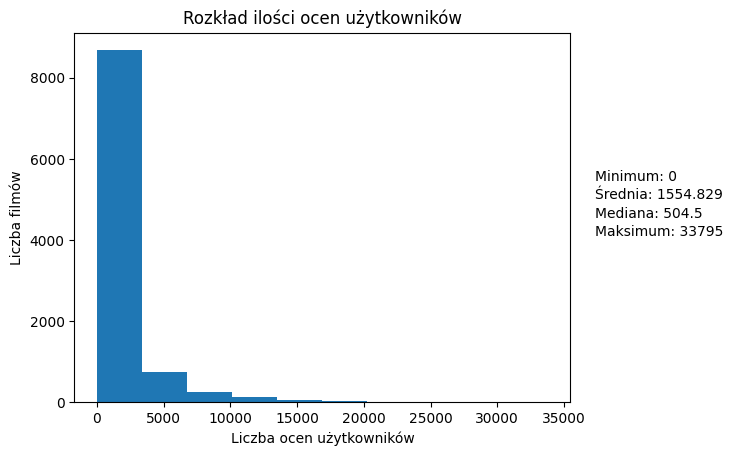

In [169]:
# Obliczenie wartości statystycznych
minimum = df["vote_count"].min()
mean = df["vote_count"].mean()
median = df["vote_count"].median()
maximum = df["vote_count"].max()

plt.hist(df["vote_count"], bins=10)
plt.xlabel("Liczba ocen użytkowników")
plt.ylabel("Liczba filmów")
plt.title("Rozkład ilości ocen użytkowników")

# Wyświetlanie wartości statystycznych
plt.text(1.05, 0.6, f"Minimum: {minimum}", transform=plt.gca().transAxes)
plt.text(1.05, 0.55, f"Średnia: {mean:.3f}", transform=plt.gca().transAxes)
plt.text(1.05, 0.5, f"Mediana: {median}", transform=plt.gca().transAxes)
plt.text(1.05, 0.45, f"Maksimum: {maximum}", transform=plt.gca().transAxes)

plt.show()

# del filtered_df1

## Budżet i dochód

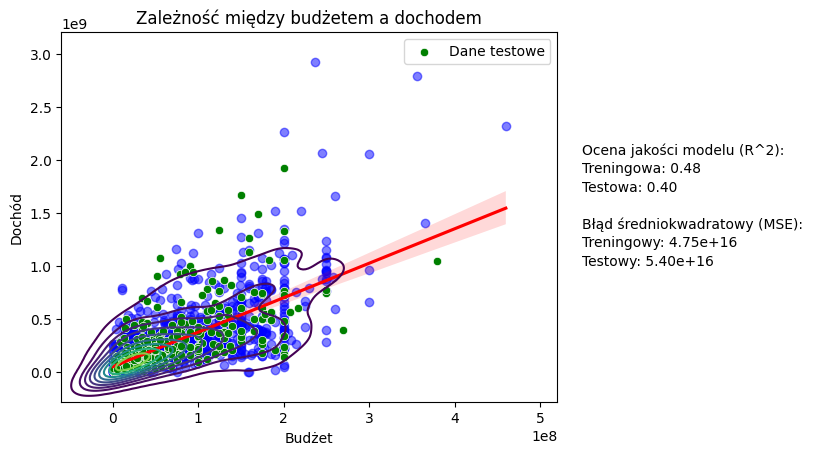

In [170]:
# Podział danych na treningowe i testowe
X = filtered_df[["budget"]]
y = filtered_df["revenue"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Inicjalizacja i trening modelu regresji liniowej
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predykcja na danych treningowych i testowych
y_train_pred = regression_model.predict(X_train)
y_test_pred = regression_model.predict(X_test)

# Obliczenie oceny jakości modelu (R^2)
train_r2_score = r2_score(y_train, y_train_pred)
test_r2_score = r2_score(y_test, y_test_pred)

# Obliczenie błędu średniokwadratowego (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

sns.regplot(
    x=X_train,
    y=y_train,
    scatter_kws={"alpha": 0.5, "color": "blue"},
    line_kws={"color": "red"},
)
sns.kdeplot(x=X_train["budget"], y=y_train, cmap="viridis")

# Dodanie danych testowych na wykresie
sns.scatterplot(x=X_test["budget"], y=y_test, color="green", label="Dane testowe")


plt.xlabel("Budżet")
plt.ylabel("Dochód")
plt.title("Zależność między budżetem a dochodem")

# Wyświetlenie oceny jakości modelu
plt.text(
    1.05,
    0.70,
    f"Ocena jakości modelu (R^2):",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)
plt.text(
    1.05,
    0.65,
    f"Treningowa: {train_r2_score:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)
plt.text(
    1.05,
    0.60,
    f"Testowa: {test_r2_score:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)

# Wyświetlenie błędu średniokwadratowego (MSE)
plt.text(
    1.05,
    0.50,
    f"Błąd średniokwadratowy (MSE):",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)
plt.text(
    1.05,
    0.45,
    f"Treningowy: {train_mse:.2e}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)
plt.text(
    1.05,
    0.40,
    f"Testowy: {test_mse:.2e}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
)


plt.legend()
plt.show()

# **Utworzenie dodatkowego parametru "cast_popularity". Eksperymenty na nim.**

In [171]:
df_cast = filtered_df.copy()  # Utworzenie pustej kolumny 'cast_popularity'
df_cast["cast_popularity"] = 0

# Iteracja po wierszach DataFrame
for index, row in df_cast.iterrows():
    cast_list = ast.literal_eval(row["cast"])
    total_popularity = 0

    # Iteracja po liście aktorów w danym wierszu
    for actor in cast_list:
        actor_popularity = float(actor["popularity"])
        total_popularity += actor_popularity

    # Przypisanie sumarycznej popularności do kolumny 'cast_popularity'
    df_cast.at[index, "cast_popularity"] = total_popularity

### ***Funkcja do obliczania regresji i rysowania wykresów modelem losowego lasu z GridSearchCV.***

In [215]:
def drawPlotForestGridSearch(x, y, xlabel=None, ylabel=None, title=None, xString=None):
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    # Definiowanie siatki parametrów do przeszukania
    param_grid = {
        "n_estimators": [100, 200, 400, 600, 800],  # liczba drzew w lesie
        "max_depth": [None, 5, 10, 20],  # maksymalna głębokość drzewa
        "min_samples_split": [
            2,
            5,
            10,
        ],  # minimalna liczba próbek wymagana do podziału węzła
    }

    # Inicjalizacja modelu i przeszukiwanie siatki parametrów
    regression_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(regression_model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Najlepsze znalezione parametry
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Użycie modelu z optymalnymi parametrami
    regression_model = RandomForestRegressor(random_state=42, **best_params)
    regression_model.fit(X_train, y_train)

    # Predykcja na danych treningowych i testowych
    y_train_pred = regression_model.predict(X_train)
    y_test_pred = regression_model.predict(X_test)

    # Obliczenie oceny jakości modelu (R^2) i błędu średniokwadratowego (MSE)
    train_r2_score = r2_score(y_train, y_train_pred)
    test_r2_score = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    sns.regplot(
        x=X_train,
        y=y_train,
        scatter_kws={"alpha": 0.5, "color": "blue"},
        line_kws={"color": "red"},
    )

    xVal = "cast_popularity"
    if xString:
        xVal = xString
    sns.kdeplot(x=X_train[xVal], y=y_train, cmap="viridis")
    sns.scatterplot(x=X_test[xVal], y=y_test, color="green", label="Dane testowe")

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    # Wyświetlenie oceny jakości modelu
    plt.text(
        1.05,
        0.70,
        f"Ocena jakości modelu (R^2):",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.65,
        f"Treningowa: {train_r2_score:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.60,
        f"Testowa: {test_r2_score:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    # Wyświetlenie błędu średniokwadratowego (MSE)
    plt.text(
        1.05,
        0.50,
        f"Błąd średniokwadratowy (MSE):",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.45,
        f"Treningowy: {train_mse:.2e}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.40,
        f"Testowy: {test_mse:.2e}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.legend()
    plt.show()

### ***Funkcja do obliczania regresji i rysowania wykresów modelem liniowym.***

In [204]:
def drawPlotLinear(x, y, xlabel=None, ylabel=None, title=None, xString=None):
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)

    # Predykcja na danych treningowych i testowych
    y_train_pred = regression_model.predict(X_train)
    y_test_pred = regression_model.predict(X_test)

    # Obliczenie oceny jakości modelu (R^2) i błędu średniokwadratowego (MSE)
    train_r2_score = r2_score(y_train, y_train_pred)
    test_r2_score = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    sns.regplot(
        x=X_train,
        y=y_train,
        scatter_kws={"alpha": 0.5, "color": "blue"},
        line_kws={"color": "red"},
    )

    xVal = "cast_popularity"
    if xString:
        xVal = xString
    sns.kdeplot(x=X_train[xVal], y=y_train, cmap="viridis")
    sns.scatterplot(x=X_test[xVal], y=y_test, color="green", label="Dane testowe")

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    # Wyświetlenie oceny jakości modelu
    plt.text(
        1.05,
        0.70,
        f"Ocena jakości modelu (R^2):",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.65,
        f"Treningowa: {train_r2_score:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.60,
        f"Testowa: {test_r2_score:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    # Wyświetlenie błędu średniokwadratowego (MSE)
    plt.text(
        1.05,
        0.50,
        f"Błąd średniokwadratowy (MSE):",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.45,
        f"Treningowy: {train_mse:.2e}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.text(
        1.05,
        0.40,
        f"Testowy: {test_mse:.2e}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.legend()
    plt.show()

#### Zależność między popularnością obsady a budżetem

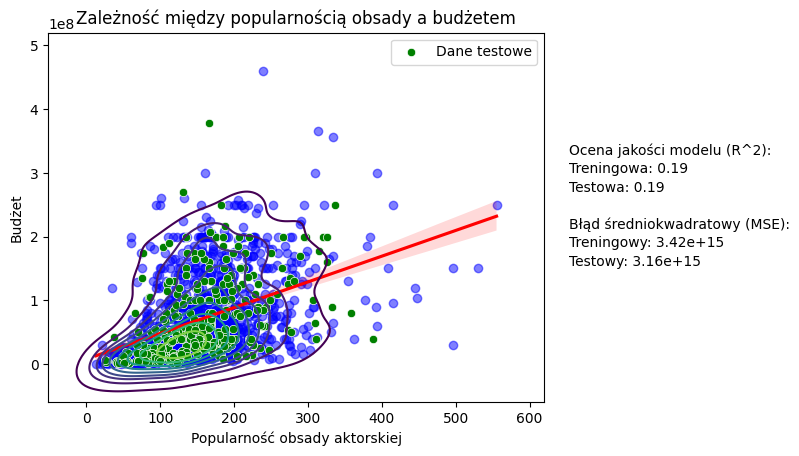

Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


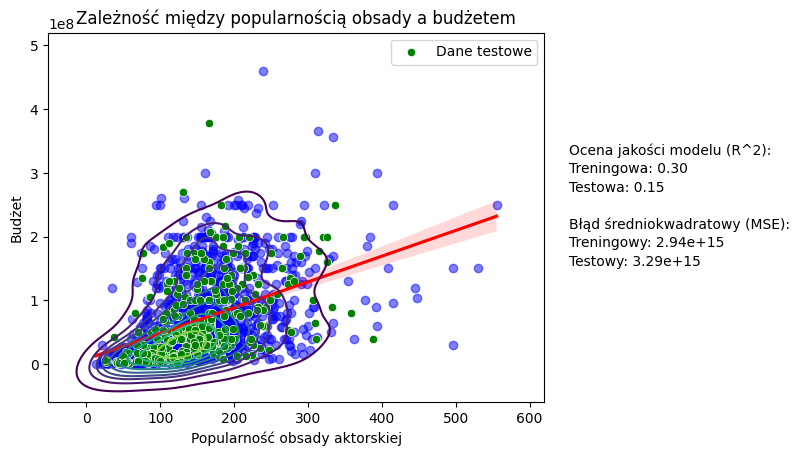

In [199]:
X = df_cast[["cast_popularity"]]
y = df_cast["budget"]
drawPlotLinear(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Budżet",
    "Zależność między popularnością obsady a budżetem",
)
drawPlotForestGridSearch(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Budżet",
    "Zależność między popularnością obsady a budżetem",
)

### Zależność między popularnością obsady a zyskiem

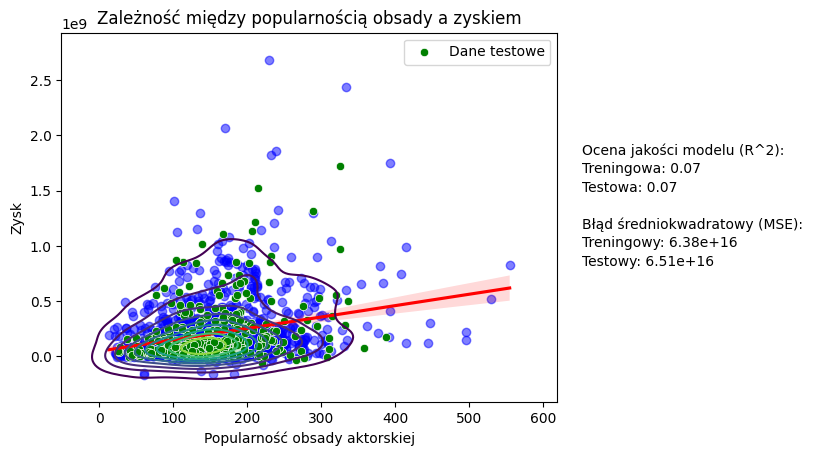

Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 800}


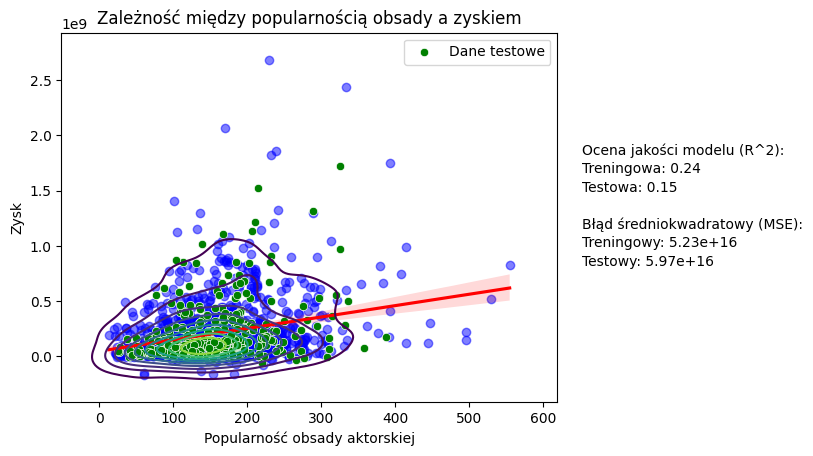

In [196]:
X = df_cast[["cast_popularity"]]
y = df_cast["profit"]

drawPlotLinear(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Zysk",
    "Zależność między popularnością obsady a zyskiem",
)
drawPlotForestGridSearch(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Zysk",
    "Zależność między popularnością obsady a zyskiem",
)

### Zależność między popularnością obsady a oceną filmu

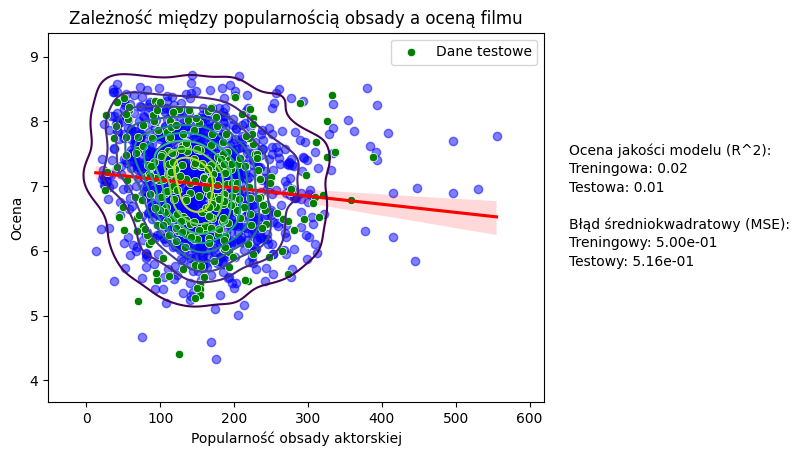

Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 1000}


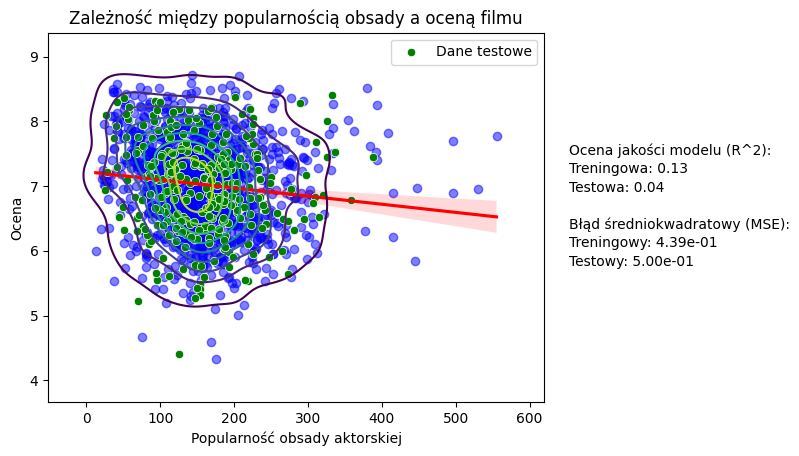

In [197]:
X = df_cast[["cast_popularity"]]
y = df_cast["vote_average"]

drawPlotLinear(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Ocena",
    "Zależność między popularnością obsady a oceną filmu",
)
drawPlotForestGridSearch(
    X,
    y,
    "Popularność obsady aktorskiej",
    "Ocena",
    "Zależność między popularnością obsady a oceną filmu",
)

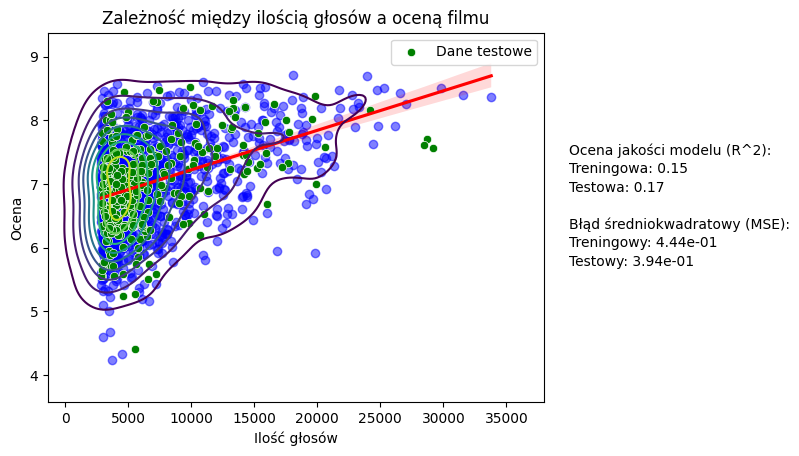

Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


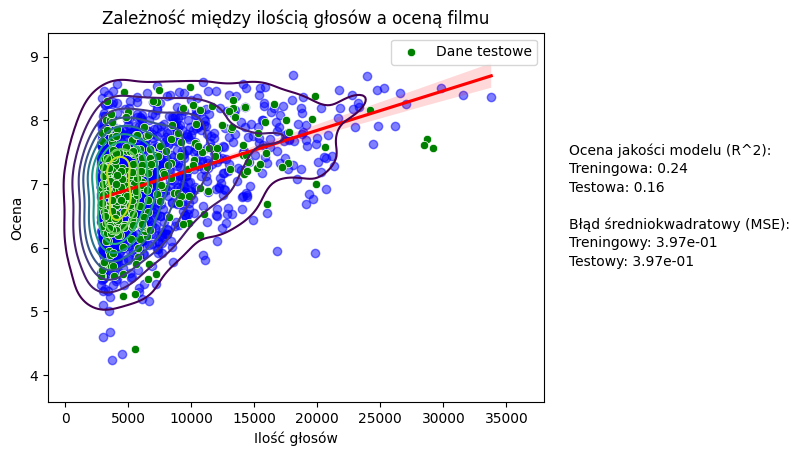

In [216]:
filtered_votes1 = df_score[(df_score["vote_count"] > 1000)]

X = filtered_votes1[["vote_count"]]
y = filtered_votes1["vote_average"]

drawPlotLinear(
    X,
    y,
    "Ilość głosów",
    "Ocena",
    "Zależność między ilością głosów a oceną filmu",
    "vote_count",
)
drawPlotForestGridSearch(
    X,
    y,
    "Ilość głosów",
    "Ocena",
    "Zależność między ilością głosów a oceną filmu",
    "vote_count",
)

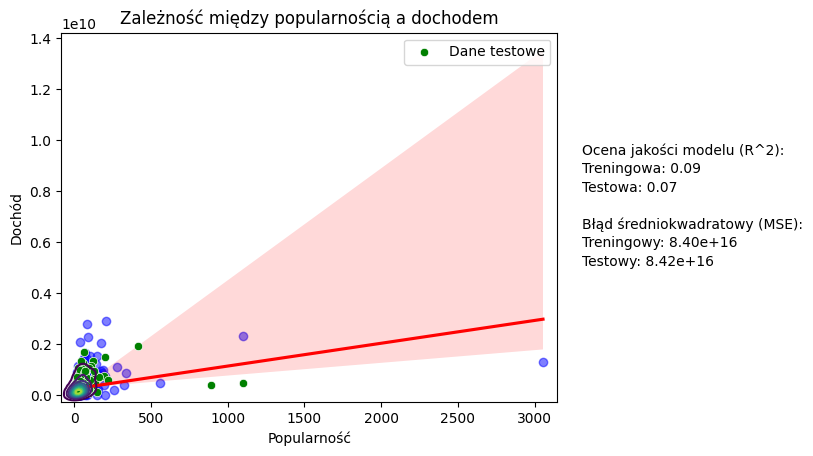

Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 800}


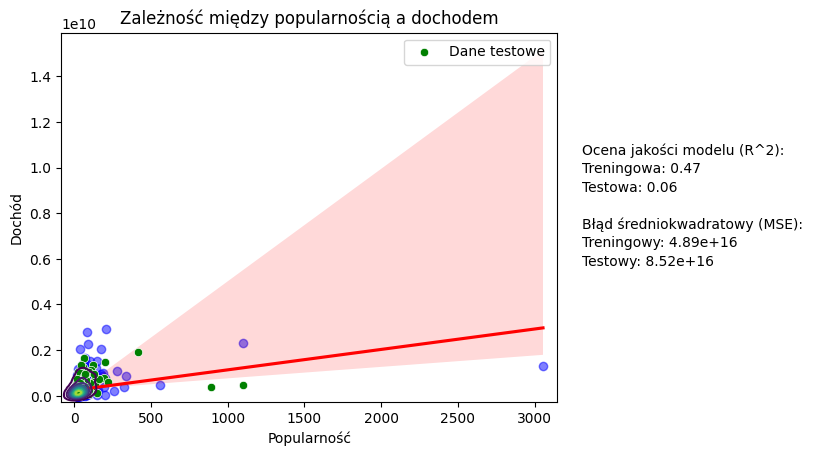

In [270]:
X = filtered_df[["popularity"]]
y = filtered_df["revenue"]

drawPlotLinear(
    X,
    y,
    "Popularność",
    "Dochód",
    "Zależność między popularnością a dochodem",
    "popularity",
)
drawPlotForestGridSearch(
    X,
    y,
    "Popularność",
    "Dochód",
    "Zależność między popularnością a dochodem",
    "popularity",
)

# **Macierz korelacji parametrów wraz z parametrem "cast_popularity"**

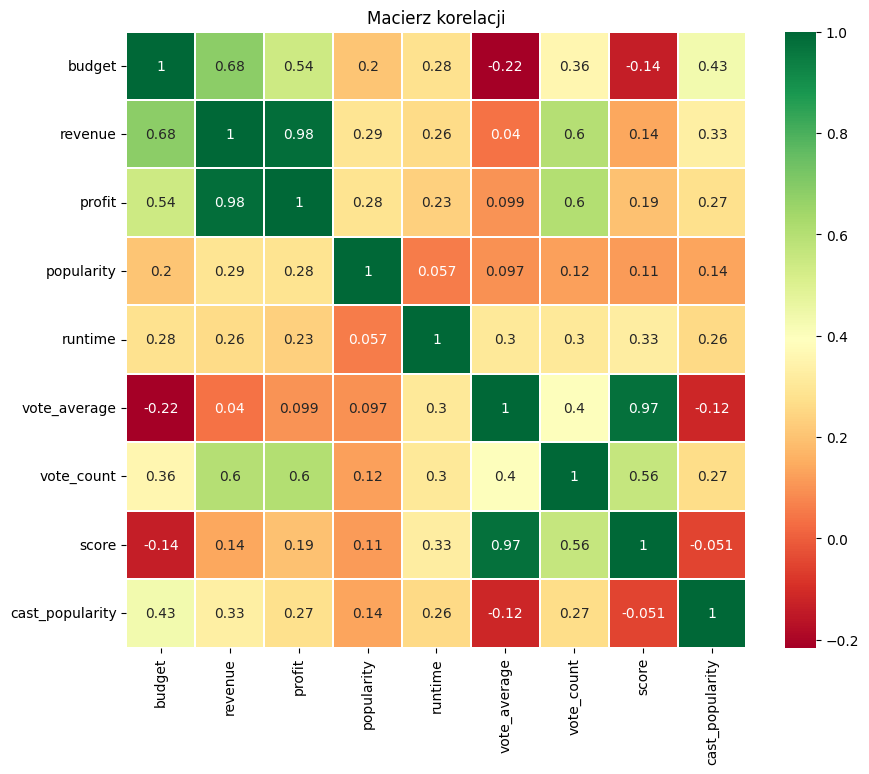

In [178]:
numeric_columns = df_cast.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_columns.corr()

# Wygenerowanie wykresu korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", linewidths=0.2)
plt.title("Macierz korelacji")
plt.show()

## **Predykcja gatunku filmu**

In [180]:
missing_values = df[["overview", "title", "director", "genres"]].isna().sum()
print(missing_values, len(df))

df_cleaned = df.dropna()
missing_values = df_cleaned[["overview", "title", "director", "genres"]].isna().sum()
print(missing_values, len(df_cleaned))

df_cleaned.head()

overview    68
title        0
director    55
genres       0
dtype: int64 9924
overview    0
title       0
director    0
genres      0
dtype: int64 7332


,title,genres,overview,tagline,release_date,budget,revenue,profit,popularity,runtime,vote_average,vote_count,cast,director,reviews,original_language,spoken_languages,production_companies,production_countries,release_year
0,John Wick: Chapter 4,"[Action, Thriller, Crime]","With the price on his head ever increasing, Jo...","No way back, one way out.",2023-03-22,90000000.0,431769198.0,341769198.0,4071.868,170,7.950,2763,"[{'name': 'Keanu Reeves', 'popularity': 72.324...","{'name': 'Chad Stahelski', 'popularity': 26.127}",['Check out the full spoiler free review at Su...,en,"['ar', 'cn', 'en', 'fr', 'de', 'ja', 'la', 'ru...","['Thunder Road', '87Eleven', 'Summit Entertain...","['DE', 'US']",2023.0
2,Spider-Man: Across the Spider-Verse,"[Action, Adventure, Animation, Science Fiction]","After reuniting with Gwen Stacy, Brooklyn’s fu...",It's how you wear the mask that matters,2023-05-31,100000000.0,221579351.0,121579351.0,2860.755,140,8.802,935,"[{'name': 'Shameik Moore', 'popularity': 67.02...","{'name': 'Joaquim Dos Santos', 'popularity': 1...",['Life as a teenager is never easy and when yo...,en,"['en', 'hi', 'it', 'es']","['Columbia Pictures', 'Sony Pictures Animation...",['US'],2023.0
3,Fast X,"[Action, Crime, Thriller]",Over many missions and against impossible odds...,The end of the road begins.,2023-05-17,340000000.0,603000000.0,263000000.0,2177.081,142,7.199,885,"[{'name': 'Vin Diesel', 'popularity': 50.536},...","{'name': 'Louis Leterrier', 'popularity': 11.378}",['MORE SPOILER-FREE MINI-REVIEWS @ https://www...,en,"['en', 'it', 'pt', 'es']","['Universal Pictures', 'Original Film', 'One R...",['US'],2023.0
4,The Black Demon,"[Horror, Thriller]",Oilman Paul Sturges' idyllic family vacation t...,Nature bites back.,2023-04-26,0.0,0.0,0.0,1746.268,100,6.351,111,"[{'name': 'Josh Lucas', 'popularity': 16.989},...","{'name': 'Adrian Grünberg', 'popularity': 3.374}",[],en,"['en', 'es']","['Mucho Mas Media', 'Silk Mass', 'The Avenue E...",['DO'],2023.0
5,The Little Mermaid,"[Adventure, Family, Fantasy, Romance]","The youngest of King Triton’s daughters, and t...","Watch and you'll see, some day I'll be, part o...",2023-05-18,250000000.0,325800000.0,75800000.0,1274.636,135,6.084,546,"[{'name': 'Halle Bailey', 'popularity': 40.6},...","{'name': 'Rob Marshall', 'popularity': 6.389}","[""Halle Bailey served a very good performance ...",en,['en'],"['Walt Disney Pictures', 'Lucamar Productions'...",['US'],2023.0


In [264]:
# Wczytanie danych z pliku CSV do dataframe
df2 = pd.read_csv("movies_preprocessed.csv")

# Usunięcie niepotrzebnych kolumn
df2 = df2.drop(
    [
        "tagline",
        "release_date",
        "budget",
        "revenue",
        "profit",
        "popularity",
        "runtime",
        "vote_average",
        "vote_count",
        "cast",
        "director",
        "reviews",
        "original_language",
        "spoken_languages",
        "production_companies",
        "production_countries",
    ],
    axis=1,
)

df2["genres"] = df2["genres"].apply(ast.literal_eval)

df2.dropna(subset=["overview", "genres"], inplace=True)

# Tworzenie listy unikalnych gatunków
all_genres = set()
for genres in df2["genres"]:
    all_genres.update(genres)

print(all_genres)

# Tworzenie kolumn binarnych dla każdego gatunku
for genre in all_genres:
    df2[genre] = df2["genres"].apply(lambda x: int(genre in x))

# Podział danych na zbiór treningowy i testowy
X = df2["overview"]
y = df2[list(all_genres)]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Przygotowanie wektorów cech dla opisów filmów
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

{'Comedy', 'Western', 'Mystery', 'Thriller', 'Drama', 'Adventure', 'Horror', 'History', 'Romance', 'Action', 'Science Fiction', 'Fantasy', 'Music', 'Animation', 'War', 'Documentary', 'TV Movie', 'Crime', 'Family'}


In [265]:
# Klasyfikacja gatunku filmu za pomocą klasyfikatora LinearSVC
classifier = OneVsRestClassifier(LinearSVC(random_state=42))
classifier.fit(X_train_vec, y_train)
y_pred = classifier.predict(X_test_vec)

# Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 11.92%


In [266]:
from sklearn.ensemble import RandomForestClassifier

classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train_vec, y_train)
y_pred = classifier.predict(X_test_vec)

# Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 5.07%


In [267]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = OneVsRestClassifier(GradientBoostingClassifier(random_state=42))
classifier.fit(X_train_vec, y_train)
y_pred = classifier.predict(X_test_vec)

# Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 6.44%


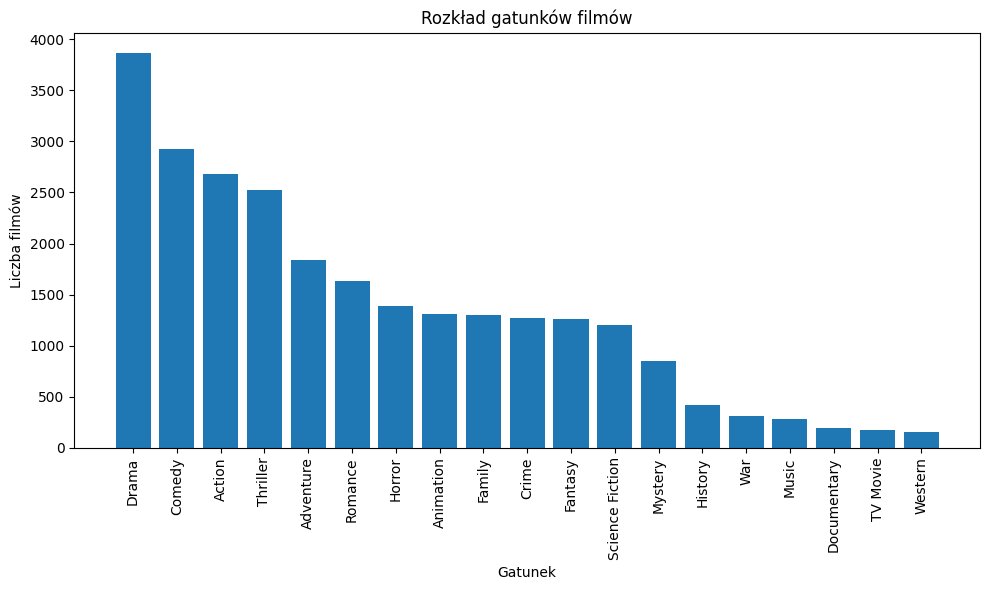

In [297]:
genre_counts = df2[list(all_genres)].sum().sort_values(ascending=False)

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Gatunek")
plt.ylabel("Liczba filmów")
plt.title("Rozkład gatunków filmów")
plt.tight_layout()

# **Rekomendacja filmu**

In [244]:
tfidf = TfidfVectorizer(stop_words="english")

df2 = df.copy()
df2["overview"] = df2["overview"].fillna("")

tfidf_matrix = tfidf.fit_transform(df2["overview"])

print(tfidf_matrix.shape)

sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df2.index, index=df2["title"]).drop_duplicates()

(9924, 28116)

In [247]:
def get_recommendations(title):
    idx = indices[title]

    mov_indices = [
        i[0]
        for i in sorted(list(enumerate(sim[idx])), key=lambda x: x[1], reverse=True)[
            1:11
        ]
    ]

    return df2["title"].iloc[mov_indices]

In [249]:
get_recommendations("John Wick")

144                  John Wick: Chapter 2
0                    John Wick: Chapter 4
160     John Wick: Chapter 3 - Parabellum
9672                    Cops & Robbersons
4236                       The Assignment
8054                                 JJ+E
3928                         The Virtuoso
6088                            Love Shot
1386                          The Outlaws
7198                      Retirement Home
Name: title, dtype: object

In [254]:
get_recommendations("Fast X")

4856                                               Capone
2747                                     Kau Pilih Siapa?
150                               The Fate of the Furious
129                                             Furious 7
7160                                      Howling Village
9616                                     Grave Encounters
122                                                    F9
433     Dragon Ball Z: Broly – The Legendary Super Saiyan
646                                        Water and Fire
9575                                                Creep
Name: title, dtype: object